In [ ]:
import os
import glob
from google.colab import drive

## load train, test and validation label arrays
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
#import tqdm as tqdm
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import random 
import cv2 
def unet_augment(sample,vertical_prob,horizontal_prob): 
  image, masks= sample['image'], sample['masks'] 
  if (random.random()<vertical_prob): 
    image=cv2.flip(image,1) 
    masks=cv2.flip(masks,1) 
  if (random.random()<horizontal_prob): 
    image=cv2.flip(image,0) 
    masks=cv2.flip(masks,0) 
  return {'image': image, 'masks': masks} 

In [ ]:
class MyDataset(Dataset):

    def __init__(self, root, img_transform = None, mask_transform = None, transform= None):
        self.root = root
        self.folders = os.listdir(root)#指定路径包含的所有文件list
        
        paths = os.listdir(os.path.join(root, 'train_images'))
        self.imgs = [os.path.join(root, 'train_images', p) for p in paths]
        self.masks = [os.path.join(root, 'train_masks', p) for p in paths]
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.transform = transform

        
    def __getitem__(self, idx):
        img_folder = os.path.join(self.root, 'train_images')
        mask_folder = os.path.join(self.root, 'train_masks')
        
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        
        img=cv2.imread(img_path)
        #img = Image.open(img_path)
        #input_net_1=img
        #input_net_2=img 

        img=cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
        img= img.reshape((256,256,3))
        #input_net_2=cv2.resize(input_net_2,(128,128), interpolation = cv2.INTER_CUBIC)
        #img = img.convert('RGB')
        #mask = Image.open(mask_path)

        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(256,256), interpolation = cv2.INTER_CUBIC)
        mask= mask.reshape((256,256,1))       


        sample = {'image': img, 'masks': mask}  

        if self.transform:
          sample=unet_augment(sample,vertical_prob=0.25,horizontal_prob=0.3)

        sample['image']= sample['image'].transpose((2, 0, 1))#The convolution function in pytorch expects data in format (N,C,H,W) N is batch size , C are channels H is height and W is width. here we convert image from (H,W,C) to (C,H,W)
        sample['masks']= sample['masks'].reshape((256,256,1)).transpose((2, 0, 1))
       
        sample["image"] = self.img_transform(img)
        
       # mask = mask.convert('RGB')
        sample["masks"] = self.mask_transform(mask)
        
        return (sample["image"],sample["masks"])

    
    def __len__(self):
        
        return len(self.imgs)
            

        

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Generate dataset
dataset = MyDataset('drive/My Drive/FDLHW', img_transform, mask_transform,transform= True)

In [ ]:
image, mask = dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
import numpy as np
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img * 255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

In [ ]:
import random
from matplotlib import pyplot as plt
# Visualize images as well as masks
def visualize_dataset(n_images, predict=None):
    images = random.sample(range(0, 670), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = dataset.__getitem__(img_no)
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title("Ground Truth Image")
        ax[i, 1].set_title("Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

[463, 59, 25, 328, 10]


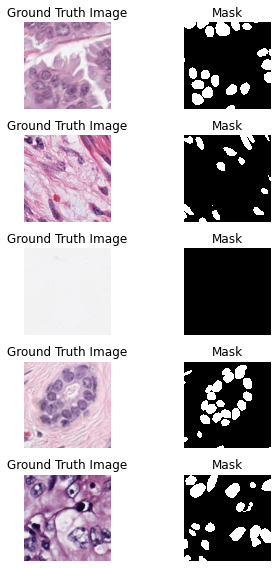

In [ ]:
visualize_dataset(5)

In [ ]:
import numpy as np
from torch.utils.data import DataLoader, random_split
split_ratio = 0.25
train_size=int(np.round(dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(dataset.__len__()*split_ratio,0))

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=20)

print("Length of train and valid datas: {}, {}".format(len(train_data), len(valid_data)))

Length of train and valid datas: 1992, 664


In [ ]:
import torch.nn as nn
        
        
ALPHA = 0.8
GAMMA = 2

class FocalDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #DICE
        intersection = (inputs * targets).sum()                            
        dice = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        
        
        #FOCAL
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        #FINAL
        final_loss=1
        
        return focal_loss      
        
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [ ]:
def write_results(ff, save_folder, epoch, train_score, val_score, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_SCORE: ')
    ff.write(str('%.3f' % train_score))
    ff.write(' VAL_SCORE: ')
    ff.write(str('%.3f' % val_score))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

In [ ]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [ ]:
#model
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.nn import functional as F


def get_backbone(name, pretrained=True):

    """ Loading backbone, defining names for skip-connections and encoder output. """

    # TODO: More backbones

    # loading backbone model
    if name == 'resnet18':
        backbone = models.resnet18(pretrained=pretrained)
    elif name == 'resnet34':
        backbone = models.resnet34(pretrained=pretrained)
    elif name == 'resnet50':
        backbone = models.resnet50(pretrained=pretrained)
    elif name == 'resnet101':
        backbone = models.resnet101(pretrained=pretrained)
    elif name == 'resnet152':
        backbone = models.resnet152(pretrained=pretrained)
    elif name == 'vgg16':
        backbone = models.vgg16_bn(pretrained=pretrained).features
    elif name == 'vgg19':
        backbone = models.vgg19_bn(pretrained=pretrained).features
    # elif name == 'inception_v3':
    #     backbone = models.inception_v3(pretrained=pretrained, aux_logits=False)
    elif name == 'densenet121':
        backbone = models.densenet121(pretrained=True).features
    elif name == 'densenet161':
        backbone = models.densenet161(pretrained=True).features
    elif name == 'densenet169':
        backbone = models.densenet169(pretrained=True).features
    elif name == 'densenet201':
        backbone = models.densenet201(pretrained=True).features
    elif name == 'unet_encoder':
        from unet_backbone import UnetEncoder
        backbone = UnetEncoder(3)
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    # specifying skip feature and output names
    if name.startswith('resnet'):
        feature_names = [None, 'relu', 'layer1', 'layer2', 'layer3']
        backbone_output = 'layer4'
    elif name == 'vgg16':
        # TODO: consider using a 'bridge' for VGG models, there is just a MaxPool between last skip and backbone output
        feature_names = ['5', '12', '22', '32', '42']
        backbone_output = '43'
    elif name == 'vgg19':
        feature_names = ['5', '12', '25', '38', '51']
        backbone_output = '52'
    # elif name == 'inception_v3':
    #     feature_names = [None, 'Mixed_5d', 'Mixed_6e']
    #     backbone_output = 'Mixed_7c'
    elif name.startswith('densenet'):
        feature_names = [None, 'relu0', 'denseblock1', 'denseblock2', 'denseblock3']
        backbone_output = 'denseblock4'
    elif name == 'unet_encoder':
        feature_names = ['module1', 'module2', 'module3', 'module4']
        backbone_output = 'module5'
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    return backbone, feature_names, backbone_output


class UpsampleBlock(nn.Module):

    # TODO: separate parametric and non-parametric classes?
    # TODO: skip connection concatenated OR added

    def __init__(self, ch_in, ch_out=None, skip_in=0, use_bn=True, parametric=False):
        super(UpsampleBlock, self).__init__()

        self.parametric = parametric
        ch_out = ch_in/2 if ch_out is None else ch_out

        # first convolution: either transposed conv, or conv following the skip connection
        if parametric:
            # versions: kernel=4 padding=1, kernel=2 padding=0
            self.up = nn.ConvTranspose2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(4, 4),
                                         stride=2, padding=1, output_padding=0, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None
        else:
            self.up = None
            ch_in = ch_in + skip_in
            self.conv1 = nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(3, 3),
                                   stride=1, padding=1, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None

        self.relu = nn.ReLU(inplace=True)

        # second convolution
        conv2_in = ch_out if not parametric else ch_out + skip_in
        self.conv2 = nn.Conv2d(in_channels=conv2_in, out_channels=ch_out, kernel_size=(3, 3),
                               stride=1, padding=1, bias=(not use_bn))
        self.bn2 = nn.BatchNorm2d(ch_out) if use_bn else None

    def forward(self, x, skip_connection=None):

        x = self.up(x) if self.parametric else F.interpolate(x, size=None, scale_factor=2, mode='bilinear',
                                                             align_corners=None)
        if self.parametric:
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)

        if skip_connection is not None:
            x = torch.cat([x, skip_connection], dim=1)

        if not self.parametric:
            x = self.conv1(x)
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.bn2 is not None else x
        x = self.relu(x)

        return x


class Unet(nn.Module):

    """ U-Net (https://arxiv.org/pdf/1505.04597.pdf) implementation with pre-trained torchvision backbones."""

    def __init__(self,
                 backbone_name='resnet50',
                 pretrained=True,
                 encoder_freeze=False,
                 classes=1,
                 decoder_filters=(256, 128, 64, 32, 16),
                 parametric_upsampling=True,
                 shortcut_features='default',
                 decoder_use_batchnorm=True):
        super(Unet, self).__init__()

        self.backbone_name = backbone_name

        self.backbone, self.shortcut_features, self.bb_out_name = get_backbone(backbone_name, pretrained=pretrained)
        shortcut_chs, bb_out_chs = self.infer_skip_channels()
        if shortcut_features != 'default':
            self.shortcut_features = shortcut_features

        # build decoder part
        self.upsample_blocks = nn.ModuleList()
        decoder_filters = decoder_filters[:len(self.shortcut_features)]  # avoiding having more blocks than skip connections
        decoder_filters_in = [bb_out_chs] + list(decoder_filters[:-1])
        num_blocks = len(self.shortcut_features)
        for i, [filters_in, filters_out] in enumerate(zip(decoder_filters_in, decoder_filters)):
            print('upsample_blocks[{}] in: {}   out: {}'.format(i, filters_in, filters_out))
            self.upsample_blocks.append(UpsampleBlock(filters_in, filters_out,
                                                      skip_in=shortcut_chs[num_blocks-i-1],
                                                      parametric=parametric_upsampling,
                                                      use_bn=decoder_use_batchnorm))

        self.final_conv = nn.Conv2d(decoder_filters[-1], classes, kernel_size=(1, 1))

        if encoder_freeze:
            self.freeze_encoder()

        self.replaced_conv1 = False  # for accommodating  inputs with different number of channels later

    def freeze_encoder(self):

        """ Freezing encoder parameters, the newly initialized decoder parameters are remaining trainable. """

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, *input):

        """ Forward propagation in U-Net. """

        x, features = self.forward_backbone(*input)

        for skip_name, upsample_block in zip(self.shortcut_features[::-1], self.upsample_blocks):
            skip_features = features[skip_name]
            x = upsample_block(x, skip_features)

        x = self.final_conv(x)
        return x

    def forward_backbone(self, x):

        """ Forward propagation in backbone encoder network.  """

        features = {None: None} if None in self.shortcut_features else dict()
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                features[name] = x
            if name == self.bb_out_name:
                break

        return x, features

    def infer_skip_channels(self):

        """ Getting the number of channels at skip connections and at the output of the encoder. """

        x = torch.zeros(1, 3, 224, 224)
        has_fullres_features = self.backbone_name.startswith('vgg') or self.backbone_name == 'unet_encoder'
        channels = [] if has_fullres_features else [0]  # only VGG has features at full resolution

        # forward run in backbone to count channels (dirty solution but works for *any* Module)
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                channels.append(x.shape[1])
            if name == self.bb_out_name:
                out_channels = x.shape[1]
                break
        return channels, out_channels

    def get_pretrained_parameters(self):
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                yield param

    def get_random_initialized_parameters(self):
        pretrained_param_names = set()
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                pretrained_param_names.add('backbone.{}'.format(name))

        for name, param in self.named_parameters():
            if name not in pretrained_param_names:
                yield param



In [ ]:
model = Unet(backbone_name='resnet18').cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3,weight_decay=0.001)
criterion = DiceBCELoss()
accuracy_metric = IoU()
num_epochs=30
#valid_loss_min = np.Inf

description:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch: 1, loss: 0.31084030866622925, IoU: 0.7264013886451721: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



###############Train Loss: 0.24364440262317658, Train IOU: 0.769759110212326###############
###############Valid Loss: 0.42452451849684997, Valid IOU: 0.6409708208897534###############


Epoch: 2, loss: 0.28205060958862305, IoU: 0.7368696928024292: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



###############Train Loss: 0.2551242455840111, Train IOU: 0.7590303599834443###############
###############Valid Loss: 0.3911632001399994, Valid IOU: 0.6689631290295545###############


Epoch: 3, loss: 0.2905014157295227, IoU: 0.7464106678962708: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]



###############Train Loss: 0.25599313735961915, Train IOU: 0.7580465269088745###############
###############Valid Loss: 0.43326393471044655, Valid IOU: 0.6358937586055082###############


Epoch: 4, loss: 0.3569524586200714, IoU: 0.7038225531578064: 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]



###############Train Loss: 0.27268622651696206, Train IOU: 0.7435343104600907###############
###############Valid Loss: 0.4044478614540661, Valid IOU: 0.6505631664220024###############


Epoch: 5, loss: 0.3109855651855469, IoU: 0.729970395565033: 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]



###############Train Loss: 0.27806210398674014, Train IOU: 0.7379008644819259###############
###############Valid Loss: 0.4964444944087197, Valid IOU: 0.5954118686563828###############


Epoch: 6, loss: 0.25237059593200684, IoU: 0.7607423067092896: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



###############Train Loss: 0.2793951243162155, Train IOU: 0.7369046187400818###############
###############Valid Loss: 0.3906113575486576, Valid IOU: 0.6557567926014171###############


Epoch: 7, loss: 0.286325603723526, IoU: 0.7318757176399231: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



###############Train Loss: 0.2738563840091228, Train IOU: 0.7419094508886337###############
###############Valid Loss: 0.4032617202576469, Valid IOU: 0.6571851846049813###############


Epoch: 8, loss: 0.27017703652381897, IoU: 0.7351458072662354: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



###############Train Loss: 0.27980893209576607, Train IOU: 0.7368593430519104###############
###############Valid Loss: 0.39819835915284996, Valid IOU: 0.6478112269850338###############


Epoch: 9, loss: 0.3044794797897339, IoU: 0.7141232490539551: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



###############Train Loss: 0.28727653220295907, Train IOU: 0.7302019673585892###############
###############Valid Loss: 0.4295933386858772, Valid IOU: 0.646258764407214###############


Epoch: 10, loss: 0.32859355211257935, IoU: 0.7207075357437134: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



###############Train Loss: 0.2949503107368946, Train IOU: 0.7234220188856125###############
###############Valid Loss: 0.40826189167359295, Valid IOU: 0.652382493019104###############


ValueError: ignored

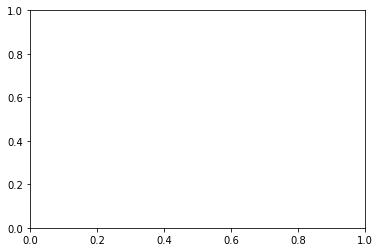

In [ ]:
#import lovasz_losses as L
#optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3,weight_decay=0.0001,momentum=0.99)
save_folder = 'drive/My Drive/FDLHW/Results_Res34'
ff=open('{}/progress.txt'.format(save_folder),'w')
total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(10):
    model.train()
  
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    p = tqdm(train_loader, desc = 'description')
    for x_train, y_train in p:
        x_train = torch.autograd.Variable(x_train).cuda()
        y_train = torch.autograd.Variable(y_train).cuda()
        optimizer.zero_grad()
        output = model(x_train)
        
      #Loss
        loss = criterion(output,y_train)
        losses_value = loss.item()
      #Score
        score = accuracy_metric(output,y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        #train_score.append(score)
        p.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    model.eval()
    with torch.no_grad():
        for image,mask in val_loader:
            image = torch.autograd.Variable(image).cuda()
            mask = torch.autograd.Variable(mask).cuda()
            output = model(image)
            
        ## Compute Loss Value.
            loss = criterion(output,mask)
            losses_value = loss.item()
        ## Compute Accuracy Score
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

        total_train_loss.append(np.mean(train_loss))
        total_train_score.append(np.mean(train_score))
        total_valid_loss.append(np.mean(valid_loss))
        total_valid_score.append(np.mean(valid_score))
        print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
        print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")
        
    write_results(ff, save_folder, epoch, total_train_score[-1], total_valid_score[-1], total_valid_loss[-1], total_valid_score[-1])

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch+20))
save_graph(total_train_loss, total_valid_loss, num_epochs, save_folder)
   

In [ ]:
import torch.nn as nn
        
        
ALPHA = 0.8
GAMMA = 2

class FocalDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #DICE
        intersection = (inputs * targets).sum()                            
        dice = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        
        
        #FOCAL
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        #FINAL
        final_loss=1
        
        return focal_loss      
        
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        
        #comment out if your model contains a sigmoid or equivalent activation layer
       # inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Utility Functions
''' when filter kernel= 3x3, padding=1 makes in&out matrix same size'''
def conv_bn_leru(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, input_channels, nclasses):
        super().__init__()
        # go down
        self.conv1 = conv_bn_leru(input_channels,64)
        self.conv2 = conv_bn_leru(64, 128)
        self.conv3 = conv_bn_leru(128, 256)
        self.conv4 = conv_bn_leru(256, 512)
        self.conv5 = conv_bn_leru(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # go up
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_leru(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_leru(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_leru(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_leru(128, 64)

        self.conv10 = nn.Conv2d(64, nclasses, 1)


        # test weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        # normalize input data
        #x = x/255.
        # go down
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # go up
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)


        output = self.conv10(x9)
        output = F.sigmoid(output)

        return output


In [ ]:
model2 = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-2,weight_decay=0.0001)
criterion = DiceBCELoss()
accuracy_metric = IoU()
num_epochs=30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [ ]:
#import lovasz_losses as L
#optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3,weight_decay=0.0001,momentum=0.99)
save_folder = 'drive/My Drive/FDLHW/Results_2'
ff=open('{}/progress.txt'.format(save_folder),'w')
total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(10):
    model.train()
  
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    p = tqdm(train_loader, desc = 'description')
    for x_train, y_train in p:
        x_train = torch.autograd.Variable(x_train).cuda()
        y_train = torch.autograd.Variable(y_train).cuda()
        optimizer.zero_grad()
        output = model(x_train)
        
      #Loss
        loss = criterion(output,y_train)
        losses_value = loss.item()
      #Score
        score = accuracy_metric(output,y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        #train_score.append(score)
        p.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    model.eval()
    with torch.no_grad():
        for image,mask in val_loader:
            image = torch.autograd.Variable(image).cuda()
            mask = torch.autograd.Variable(mask).cuda()
            output = model(image)
            
        ## Compute Loss Value.
            loss = criterion(output,mask)
            losses_value = loss.item()
        ## Compute Accuracy Score
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

        total_train_loss.append(np.mean(train_loss))
        total_train_score.append(np.mean(train_score))
        total_valid_loss.append(np.mean(valid_loss))
        total_valid_score.append(np.mean(valid_score))
        print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
        print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")
        
    write_results(ff, save_folder, epoch, total_train_score[-1], total_valid_score[-1], total_valid_loss[-1], total_valid_score[-1])

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))
save_graph(total_train_loss, total_val_loss, num_epochs, save_folder)
   

description:   0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: ignored